In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['axes.titlesize']=30
mpl.rcParams['legend.fontsize']=20
mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.grid']=True
path='./Resources/Aquisition/'

In [2]:
# import del secondo set di dati
t1=pd.read_csv(path+'scope_1_1.csv',usecols=[0,1],names=["time","ch1"],dtype=np.float64,skiprows=2)
t2=pd.read_csv(path+'scope_1_2.csv',usecols=[0,1],names=["time","ch2"],dtype=np.float64,skiprows=2)
tt=pd.DataFrame({'time':t1['time'],'ch1':t1['ch1'],'ch2':t2['ch2']})
dati2=tt.set_index('time')


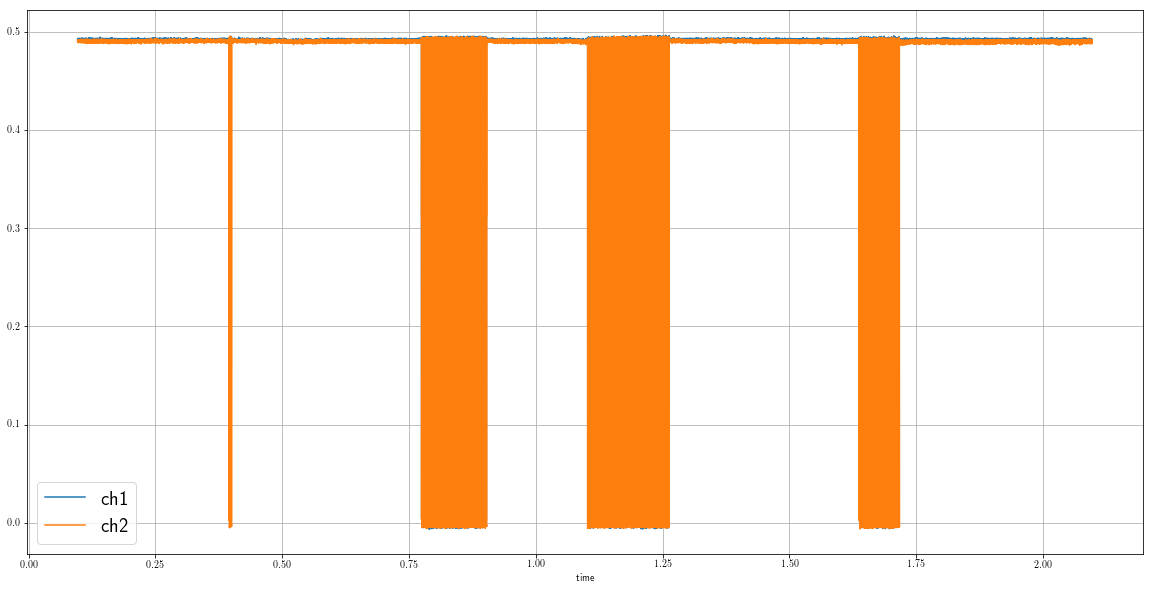

In [3]:
dati2.plot(figsize=(20,10))


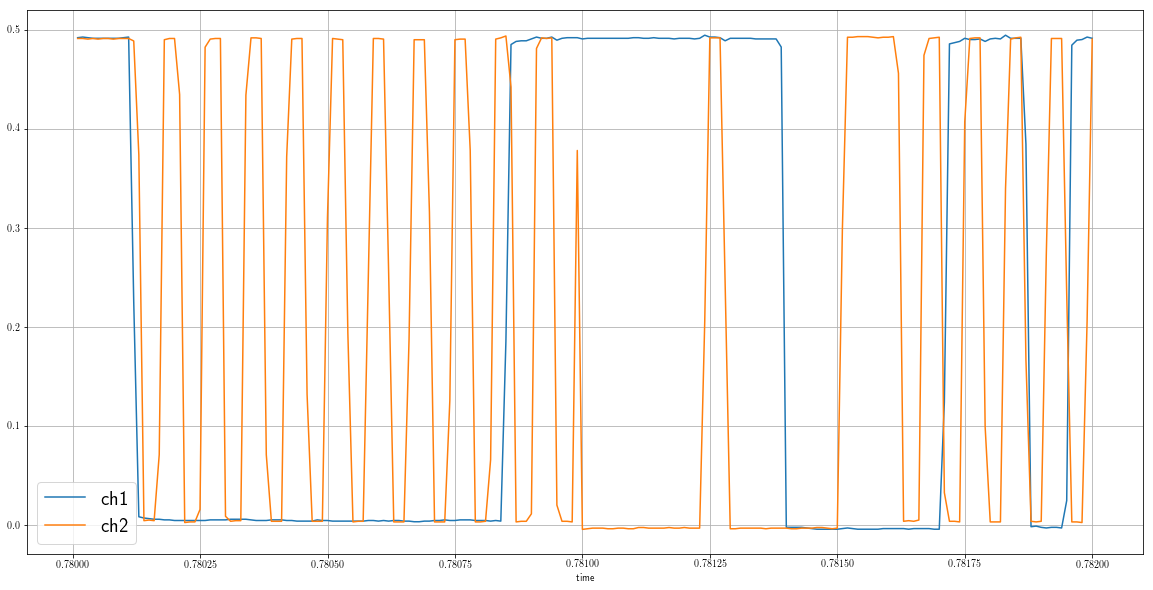

In [4]:
finestra=[0.77,0.9]
finestra=[0.78,0.782]
dati2.iloc[(dati2.index>finestra[0])*(dati2.index<finestra[1])].plot(figsize=(20,10))


clock    1
data     1
Name: 0.37687993256, dtype: int64

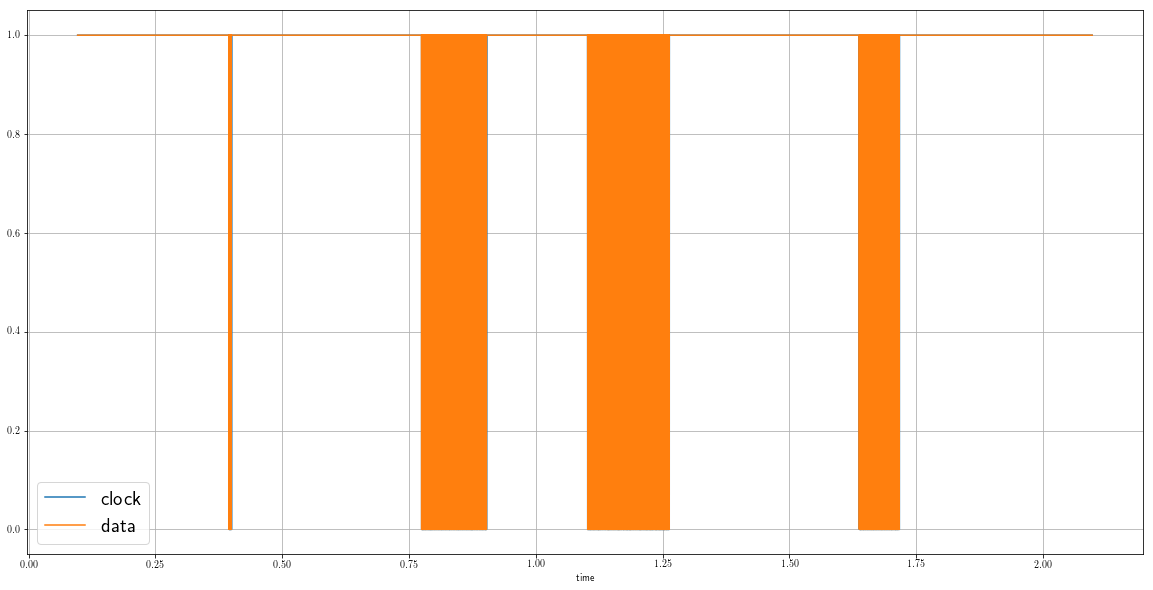

In [101]:
sogliaTTL=0.7*(5/10)
data=dati2['ch1'].values
clock=dati2['ch2'].values

data=data>sogliaTTL
clock=clock>sogliaTTL
dati2Digital=pd.DataFrame({'data':data, 'clock':clock},index=dati2.index,dtype=np.int64)


dati2Digital.plot(figsize=(20,10)) # contains digitalized data, array of bool
dati2Digital.iloc[28000]

In [10]:
muS=10**-6
Tsampling=10*muS
Tclk=80*muS
Tclkduty=Tclk/2
TclkHb4CtTx=50*muS
TminCD=5*muS
TminDC=5*muS
TmaxDC=25*muS
TClkL4inh=100*muS
Tmax4CtGenClkPulses=15*10**3*muS
Tmax4PcktSending=2*10**3*muS
TmaxCtResponse=20*10**3*muS

# the names below can be obtained as:
# cat <the_precedent_as_a_file> | gawk -v FS="=" '{print $1;}' | sed s/^T/t/
# the final is
# parallel echo {1}={2}/{3} ::::+ <result of precedent> ::::+  <(cat poi | gawk -v FS="=" '{print $1;}') ::: Tsampling

tsampling=Tsampling/Tsampling
tclk=Tclk/Tsampling
tclkduty=Tclkduty/Tsampling
tclkHb4CtTx=TclkHb4CtTx/Tsampling
tminCD=np.ceil(TminCD/Tsampling)
tminDC=np.ceil(TminDC/Tsampling)
tmaxDC=np.ceil(TmaxDC/Tsampling)
tClkL4inh=TClkL4inh/Tsampling
tmax4CtGenClkPulses=Tmax4CtGenClkPulses/Tsampling
tmax4PcktSending=Tmax4PcktSending/Tsampling
tmaxCtResponse=TmaxCtResponse/Tsampling

(tsampling ,tclk ,tclkduty ,tclkHb4CtTx ,tminCD ,tminDC ,tmaxDC ,tClkL4inh ,tmax4CtGenClkPulses ,tmax4PcktSending ,tmaxCtResponse)

(1.0,
 8.0,
 4.0,
 5.0,
 1.0,
 1.0,
 3.0,
 10.0,
 1500.0,
 200.00000000000003,
 2000.0000000000002)

In [124]:
class readSig():
    def __init__(self,clock,data,start=0):
        self.t=counter(len(clock),count=start)
        
        self.C=True
        self.D=True
        self.Co=True
        self.Do=True
        self.CDo=(self.Co,self.Do) # start in pause state
        self.CD=(self.C,self.D)
        
        self.buf=[]
        self.clock=clock
        self.data=data
        self.status='idle'
        self.counters={}
        self.packets=[]
        
        self.counters['endCom']=counter(10,en=False)
         
    def tick(s):
        # first upload t, C_lock-D_ata-s_tatus, and all counters
        s.t.inc()
        
        s.C=s.clock[s.t.count]
        s.D=s.data[s.t.count]
        s.CD=(s.C,s.D)
        
        for k in s.counters:
            s.counters[k].inc()
        
        # here starts the logic
        if (s.status=='idle'):
            if (s.CD==HH):
                pass
            elif (s.CD==HL):
                s.status='dhc'
                s.counters['tminDC']=counter(tminDC)
                s.counters['tmaxDC']=counter(tmaxDC)
                s.to_acq=True
            elif (s.CD==LH):
                s.status='hdc'
                s.counters['tClkL4inh']=counter(tClkL4inh)
            else:
                raise ValueError('clock and data changed simultaneously!')
        elif (s.status=='dhc'):
            if s.counters['tmaxDC']:
                raise CounterError('too much time from data low and clock')
            if (len(s.buf)<11):
                if (s.Co and not s.C):
                    s.buf.append(s.D)
                    s.counters['tmaxDC'].hreset()    
                if (s.Co and s.C):
                    pass
                if (not s.Co and not s.C):
                    pass
                if (not s.Co and s.C):
                    pass
            else:
                s.counters['endCom'].enable()
                if (s.counters['endCom'] and s.C and s.D):
                    s.status='idle'
                    s.packets.append(s.buf)
                    s.buf=[]
                    s.counters['endCom']=counter(10,en=False)
        elif (s.status=='hdc'):
            print('i\'m in host to device communication, now return')
            raise ValueError('hdc not implemented')
            #return
        else:
            print('i should not be here, last else')
            raise ValueError('else non dovrei essere qui')
            #return
        s.Co=s.C    
        s.Do=s.D
        s.CDo=s.CD
        

In [125]:
# 29840
R=readSig(clock,data,start=29835)
for i in range(250):
    R.tick()
    print('i=%d, count=%d, status = %s, s.C=%d, s.D=%d, buf=%s'%(i,R.t.count,R.status,R.C,R.D,R.buf))
    #if (R.status != 'idle'):
    #    print (R.t.count)
    #   break


i=0, count=29836, status = idle, s.C=1, s.D=1, buf=[]
i=1, count=29837, status = idle, s.C=1, s.D=1, buf=[]
i=2, count=29838, status = idle, s.C=1, s.D=1, buf=[]
i=3, count=29839, status = idle, s.C=1, s.D=1, buf=[]
i=4, count=29840, status = dhc, s.C=1, s.D=0, buf=[]
i=5, count=29841, status = dhc, s.C=1, s.D=0, buf=[]
i=6, count=29842, status = dhc, s.C=0, s.D=0, buf=[False]
i=7, count=29843, status = dhc, s.C=0, s.D=0, buf=[False]
i=8, count=29844, status = dhc, s.C=0, s.D=0, buf=[False]
i=9, count=29845, status = dhc, s.C=0, s.D=0, buf=[False]
i=10, count=29846, status = dhc, s.C=1, s.D=0, buf=[False]
i=11, count=29847, status = dhc, s.C=1, s.D=0, buf=[False]
i=12, count=29848, status = dhc, s.C=1, s.D=0, buf=[False]
i=13, count=29849, status = dhc, s.C=1, s.D=0, buf=[False]
i=14, count=29850, status = dhc, s.C=0, s.D=0, buf=[False, False]
i=15, count=29851, status = dhc, s.C=0, s.D=0, buf=[False, False]
i=16, count=29852, status = dhc, s.C=0, s.D=0, buf=[False, False]
i=17, count=

ValueError: hdc not implemented

In [126]:
R.packets[0]
R.packets[1]

[False, False, False, False, False, False, False, False, False, True, True]

In [59]:
class packet():
    def __init__(self):
        self.byte=[]
        self.direction=0 # 0 for H2D, 1 for D2H

HH=(True,True)
HL=(True,False)
LH=(False,True)
LL=(False,False)
H=True
L=False

class CounterError(Exception):
    def __init__(self,msg):
        super().__init__(msg)

class counter():
    def __init__(self,limit,count=0,en=True):
        self.limit=int(limit)
        self.finish=False
        self.count=count
        self.en=en
    def inc(self):
        if (self.en and not self.finish):
            self.count=self.count+1
        if (self.count==self.limit):
            self.finish=True
        return self
    def reset(self):
        self.count=0
        self.finish=False
        return self
    def hreset(self):
        self.en=False
        self.reset()
        return self
    def enable(self):
        self.en=True
    def disable(self):
        self.en=False
    def __bool__(self):
        return (self.finish and self.en)


In [108]:
A=counter(3)
A.inc().inc().count
A.hreset()
A.reset()

a=[]
b=[1,2,3]
a.append(b)
a.append(b)
a

print('%s'%(a))

[[1, 2, 3], [1, 2, 3]]


In [30]:
A={}
A['t1']=counter(2)
A['t2']=counter(5)


for i in range (6):
    print('i is:', i)
    for k in A:
        print(k, ' = ', bool(A[k]))
        A[k].inc()



i is: 0
t1  =  False
t2  =  False
i is: 1
t1  =  False
t2  =  False
i is: 2
t1  =  True
t2  =  False
i is: 3
t1  =  True
t2  =  False
i is: 4
t1  =  True
t2  =  False
i is: 5
t1  =  True
t2  =  True


In [45]:
global tmp

try:
    raise CounterError('fdsfsdfsdf')
except CounterError as e:
    print(e)
    tmp=e
    
tmp

fdsfsdfsdf


__main__.CounterError('fdsfsdfsdf')

In [48]:
True and not False

True

In [265]:
A=counter(34)
print(type(A))
A

A.limit
A

NameError: name 'limit' is not defined

In [218]:
class dict2(dict):
    def __getattr__(self, name):
        return self[name]
    def __setattr__(self, name, value):
        super().__setattr__(name, value)

A=dict2()

class dsa():
    def __init__(self,p,q):
        self.p=p
        self.q=q

In [226]:
dsaO=dsa(3,4)
dsaO.r=5
dsaO.r

5